# Problema 6: sientate recto

En este problema, estudiaremos unos datos medicos de ciertos pacientes, algunos tienen problemas de espalda, otros no. El objetivo será entrenar una serie de modelos para predecir si un paciente puede desarollar problemas de espalda basandose en sus datos.

In [154]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, HTML
from sklearn.metrics import  ConfusionMatrixDisplay,\
                  classification_report,  RocCurveDisplay, \
                    accuracy_score, f1_score, precision_score, recall_score
show_html = lambda html: display(HTML(html))
def save_results(clf, X_test, y_test, nclf, df):
    df.loc[nclf,'test acc'] = accuracy_score(y_test, clf.predict(X_test))
    df.loc[nclf,'precision score (W)'] = precision_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'recall score (W)'] = recall_score(y_test, clf.predict(X_test), average='weighted')
    df.loc[nclf,'f1 score (W)'] = f1_score(y_test, clf.predict(X_test), average='weighted')
    return df
results = pd.DataFrame()

## Los Datos

Leemos los datos de APAFib

In [155]:
import apafib
data = apafib.load_column()

In [156]:
data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


Vemos que no tenemos ningun valor perdido

In [157]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pelvic_incidence,310.0,NaN,NaN,NaN,60.496484,17.236109,26.15,46.4325,58.69,72.88,129.83
pelvic_tilt,310.0,NaN,NaN,NaN,17.542903,10.00814,-6.55,10.6675,16.36,22.12,49.43
lumbar_lordosis_angle,310.0,NaN,NaN,NaN,51.93071,18.553766,14.0,37.0,49.565,63.0,125.74
sacral_slope,310.0,NaN,NaN,NaN,42.953871,13.422748,13.37,33.3475,42.405,52.6925,121.43
pelvic_radius,310.0,NaN,NaN,NaN,117.920548,13.317629,70.08,110.71,118.265,125.4675,163.07
degree_spondylolisthesis,310.0,NaN,NaN,NaN,26.296742,37.558883,-11.06,1.6,11.765,41.285,418.54
class,310,3,SL,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Vemos que la distribución de los datos no es extraña, podriamos pensar que el valor 120 del sacral_slope es un outlier, pero como no es muy exagerado, en este estudio no se ha considerado como tal.

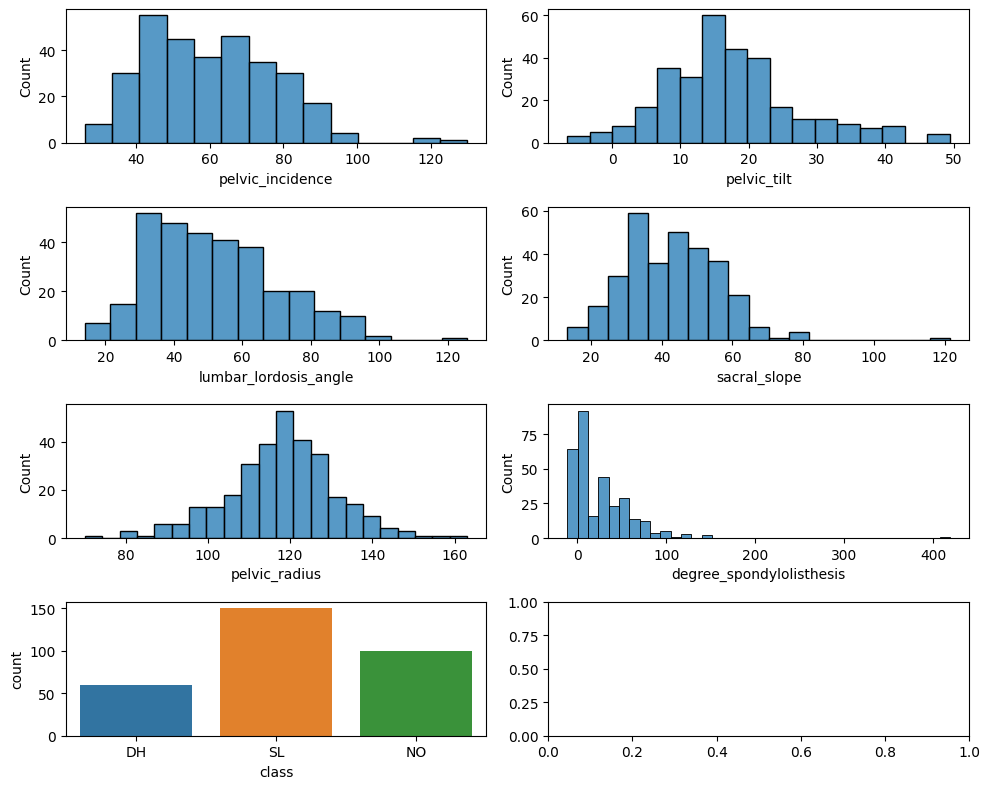

In [158]:
fig, axes = plt.subplots(4,2,figsize=(10,8))
for i, c in enumerate(data.columns[:15]):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
plt.tight_layout()

Separamos la variable a predecir de las demas

In [159]:
X = data.drop('class',axis=1)
y = data['class']

Separamos los datos en conjunto de entrenamiento y de test

In [160]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Puesto que el rango de valores de las variables es dispar, normalizaremos los datos

In [161]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

## Modelos

In [162]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

Empezaremos con el modelo de regresión logistica

In [163]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_s,y_train)
print(np.mean(cross_val_score(lr,X_train_s,y_train,cv=10)))

0.743073593073593


De entrada, sin explorar los hiperparametros, obtenemos un resultado bastante decente, vamos a ver si se puede mejorar cambiando los parametros por defecto

In [164]:
param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_s, y_train)
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
20,"{'C': 1000.0, 'penalty': 'l2'}",0.871861,1
18,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.867100,2
17,"{'C': 125.89254117941663, 'penalty': 'l2'}",0.867100,2
16,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.867100,2
19,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.862554,5


Vemos que obtenemos una mejora sustancial respecto a la versión "normal" del modelo.
A continuación podemos ver el informde de clasificación

In [165]:
print(classification_report(lr_gs.predict(X_test_s),y_test))

              precision    recall  f1-score   support

          DH       0.50      0.77      0.61        13
          NO       0.83      0.71      0.77        35
          SL       0.98      0.93      0.95        45

    accuracy                           0.83        93
   macro avg       0.77      0.81      0.78        93
weighted avg       0.86      0.83      0.84        93



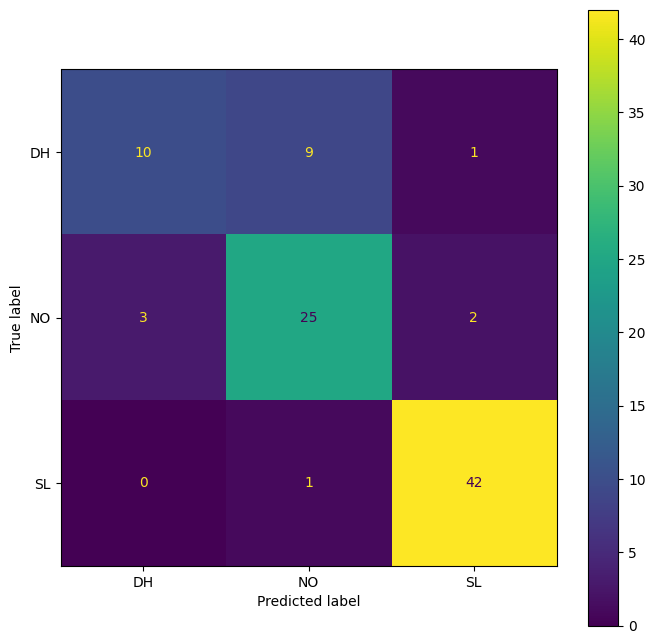

In [166]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s, y_test, ax=plt.subplot())

In [167]:
results = save_results(lr_gs, X_test_s, y_test, 'Logistic Regression', results)

El siguiente modelo que veremos es el SVC tanto con su kernel polinomico tanto con su kernel RBF.
Haremos directamente la exploración de hiperparametros.

In [168]:
from sklearn.svm import SVC
param = {'C':10**np.linspace(-3,3,101)}

psvc = SVC(kernel='poly', max_iter=1000000, random_state=0, probability=True)
psvc_gs = GridSearchCV(psvc,param,cv=5, n_jobs=-1, refit=True)
psvc_gs.fit(X_train_s, y_train)

rsvc = SVC(kernel='rbf', max_iter=1000000, random_state=0, probability=True)
rsvc_gs = GridSearchCV(rsvc,param,cv=5, n_jobs=-1, refit=True)
rsvc_gs.fit(X_train_s, y_train)

GridSearchCV(cv=5,
             estimator=SVC(max_iter=1000000, probability=True, random_state=0),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03, 7.94328235...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])})

In [169]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
show_html(pd.DataFrame(rsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
56,{'C': 2.2908676527677723},0.889746,1
55,{'C': 1.9952623149688788},0.889641,2
58,{'C': 3.019951720402016},0.884989,3
51,{'C': 1.1481536214968828},0.880444,4
54,{'C': 1.7378008287493745},0.880444,4


,params,mean_test_score,rank_test_score
62,{'C': 5.248074602497723},0.871247,1
64,{'C': 6.918309709189363},0.871247,1
66,{'C': 9.120108393559097},0.866702,3
63,{'C': 6.025595860743575},0.866596,4
69,{'C': 13.803842646028839},0.862156,5


Vemos que los dos modelos son muy muy parecidos, veamos el reporte de clasificación a ver si sacamos algo mas en claro

In [170]:
print("---------------------------Polynomial Kernel---------------------------")
print(classification_report(psvc_gs.predict(X_test_s), y_test))
print()
print("-----------------------------Radial Kernel-----------------------------")
print(classification_report(rsvc_gs.predict(X_test_s), y_test))

---------------------------Polynomial Kernel---------------------------
              precision    recall  f1-score   support

          DH       0.50      0.59      0.54        17
          NO       0.70      0.68      0.69        31
          SL       0.98      0.93      0.95        45

    accuracy                           0.78        93
   macro avg       0.73      0.73      0.73        93
weighted avg       0.80      0.78      0.79        93


-----------------------------Radial Kernel-----------------------------
              precision    recall  f1-score   support

          DH       0.55      0.58      0.56        19
          NO       0.70      0.68      0.69        31
          SL       0.95      0.95      0.95        43

    accuracy                           0.78        93
   macro avg       0.73      0.74      0.74        93
weighted avg       0.79      0.78      0.79        93



Vemos que los reportes de clasificación son tambien muy parecidos. Nos damos cuenta que los dos modelos se sobreajustan ligeramente a los datos de entrenamiento, puesto que ambos obtienen puntuaciones ligeramente inferiores cuando se evaluan con los datos de test respecto a sus puntaciones con los datos de entrenamiento

Dicho esto, nos quedaremos con el modelo RBF ya que obtiene resultados ligeramente mejores en algunos de los campos.

In [171]:
results = save_results(psvc_gs, X_test_s, y_test, 'RBF SVC', results)

Vamos a comparar el modelo RBF de SVC con el entrenado anteriormente, el de regresión logistica

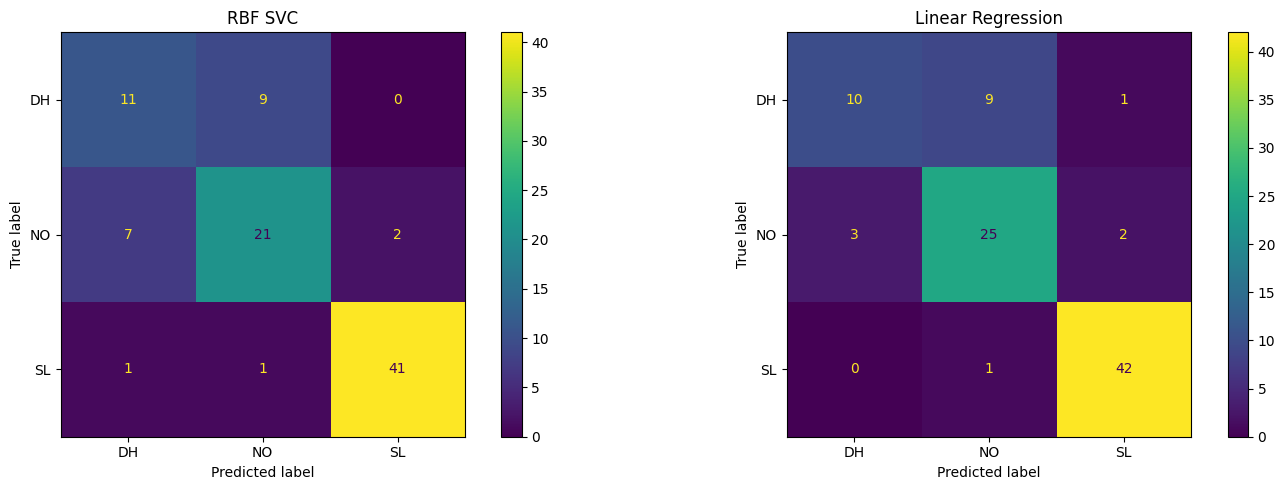

In [172]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = axes.reshape(-1)[0]
ax.title.set_text('RBF SVC')
ConfusionMatrixDisplay.from_estimator(rsvc_gs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[1]
ax.title.set_text('Logistic Regression')
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s, y_test, ax=ax)
plt.tight_layout()

Comparando las matrices de confusión, vemos que, mas o menos, los dos modelos confunden los mismo ejemplos de clase. Nos damos cuenta también que el modelo de regresión logistica, suele acertar alun ejemplo mas.

In [173]:
results.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Logistic Regression,0.827957,0.827382,0.827957,0.819824
RBF SVC,0.784946,0.776566,0.784946,0.779699


In [174]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from skopt import BayesSearchCV

Vamos a comparar ahora los modelos de RandomForest y de GradientBoosting a ver como se desempeñan en la tarea:

In [192]:
param = {'n_estimators':[10,100, 200],
         'min_samples_split': [2,4,32],
         'min_samples_leaf': [2,4,32],
         'max_features': [1,2,32]
         }

rf=RandomForestClassifier(warm_start=True, random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train_s, y_train)

BayesSearchCV(cv=5,
              estimator=RandomForestClassifier(random_state=0, warm_start=True),
              n_iter=15, n_jobs=-1, random_state=0,
              search_spaces={'max_features': [1, 2, 32],
                             'min_samples_leaf': [2, 4, 32],
                             'min_samples_split': [2, 4, 32],
                             'n_estimators': [10, 100, 200]})

In [191]:
param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
gb_bs =  BayesSearchCV(gb,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train_s, y_train);

In [177]:
print("---------------------------Random Forest---------------------------")
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
print(classification_report(rf_bs.predict(X_test_s), y_test))
print()
print("-----------------------------Gradient Boosting-----------------------------")
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
print(classification_report(gb_bs.predict(X_test_s), y_test))

---------------------------Random Forest---------------------------


,params,mean_test_score,rank_test_score
12,"{'max_features': 32, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}",0.871142,1
14,"{'max_features': 32, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}",0.871142,1
0,"{'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}",0.861945,3
9,"{'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}",0.848097,4
2,"{'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10}",0.843552,5


              precision    recall  f1-score   support

          DH       0.50      0.71      0.59        14
          NO       0.80      0.69      0.74        35
          SL       0.95      0.93      0.94        44

    accuracy                           0.81        93
   macro avg       0.75      0.78      0.76        93
weighted avg       0.83      0.81      0.81        93


-----------------------------Gradient Boosting-----------------------------


,params,mean_test_score,rank_test_score
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 10}",0.852748,1
7,"{'criterion': 'squared_error', 'learning_rate': 3.0, 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 5}",0.843446,2
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 25}",0.843340,3
12,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 10}",0.834355,4
14,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 10}",0.834249,5


              precision    recall  f1-score   support

          DH       0.40      0.53      0.46        15
          NO       0.73      0.65      0.69        34
          SL       0.95      0.93      0.94        44

    accuracy                           0.76        93
   macro avg       0.70      0.70      0.70        93
weighted avg       0.78      0.76      0.77        93



Vemos que los dos modelos son bastante parecidos en resultados. De la misma forma que le pasava al SVC, también se subreajustan ligeralente.
Puesto que el RandomForest ha obtenido resultados mejores, será con el que realizaremos las siguientes pruevas.

In [178]:
results = save_results(rf_bs, X_test_s, y_test, 'Random Forest', results)

Primero compararemos el RanfomForest con los dos modelos anteriores, tanto con la regresion logistica, como con el SVC

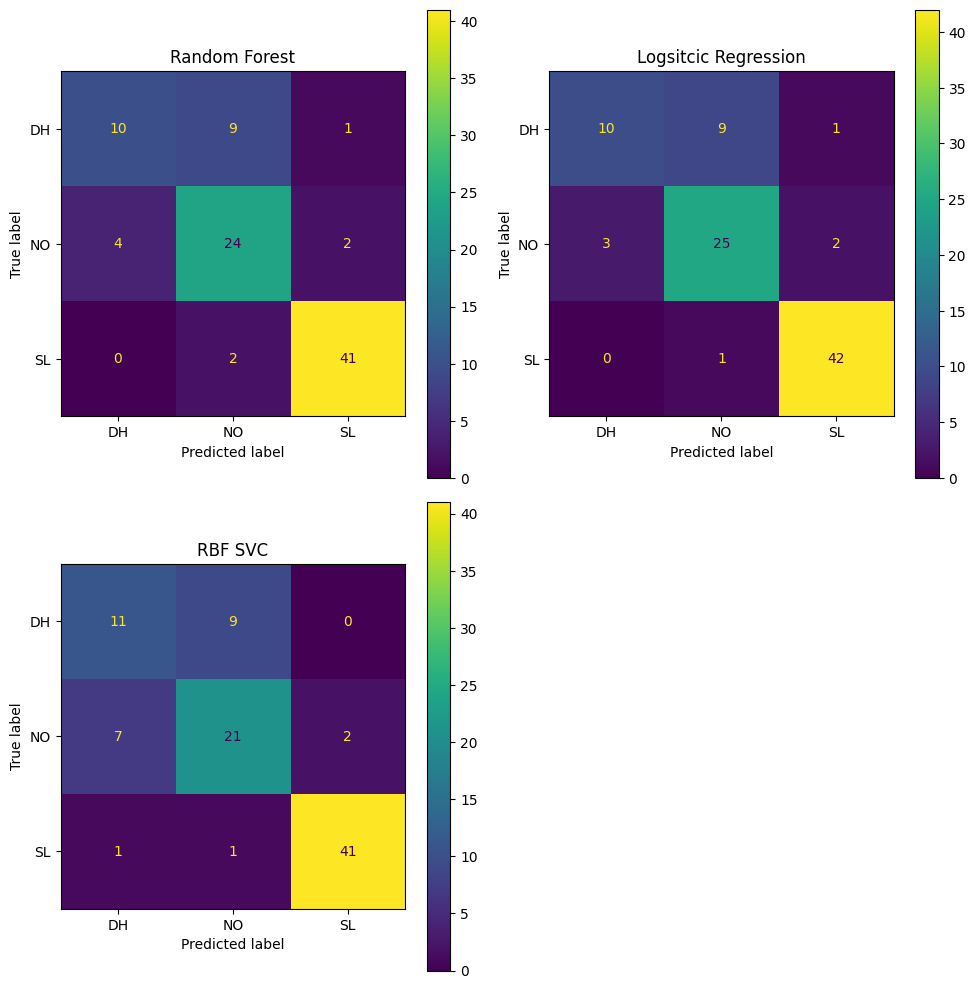

In [193]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
ax = axes.reshape(-1)[0]
ax.title.set_text('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[1]
ax.title.set_text('Logsitcic Regression')
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[2]
ax.title.set_text('RBF SVC')
ConfusionMatrixDisplay.from_estimator(rsvc_gs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[3]
fig.delaxes(ax)
plt.tight_layout()

Vemos, otra vez, que el RandomForest tambien confunde aproximadamente los mismo ejemplos que los otros dos modelos, no obstante, vemos que este modelo es capaz de plantarle cara a la regresión logistica

In [180]:
results.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Logistic Regression,0.827957,0.827382,0.827957,0.819824
Random Forest,0.806452,0.805649,0.806452,0.800508
RBF SVC,0.784946,0.776566,0.784946,0.779699


Por ultimo, vamos a intentar combinar los tres modelos mediente un sistema de votación, a ver si podemos mejorar sus resultados

In [194]:
from sklearn.ensemble import VotingClassifier

In [181]:
vs1 = VotingClassifier([('rf', rf_bs.best_estimator_),
                        ('lr', lr_gs.best_estimator_),
                        ('svc', rsvc_gs.best_estimator_)],voting='soft', n_jobs=-1)
print(np.mean(cross_val_score(vs1,X_train_s,y_train,cv=5)))                             
vs1.fit(X_train_s, y_train);   

0.8896405919661733


In [182]:
print(classification_report(vs1.predict(X_test_s), y_test))

              precision    recall  f1-score   support

          DH       0.55      0.73      0.63        15
          NO       0.80      0.73      0.76        33
          SL       0.98      0.93      0.95        45

    accuracy                           0.83        93
   macro avg       0.78      0.80      0.78        93
weighted avg       0.85      0.83      0.83        93



A primera vista, con el resultado de la validación cruzada, podriamos pensar que si que hemos obtenido un resultado significativamente mejor, no obstante al mirar el informe de clasificación nos damos cuenta que este modelo tambien se ha sobre ajustado un poco a los datos de entrenamiento y que su desmenpeño real es un poco peor

In [183]:
results = save_results(vs1, X_test_s, y_test, 'Voting Classifier', results)

Vamos a comparar los cuatro modelos que hemos visto: la regresión logistica, el SVC, el RandomForest y el clasificador por votación

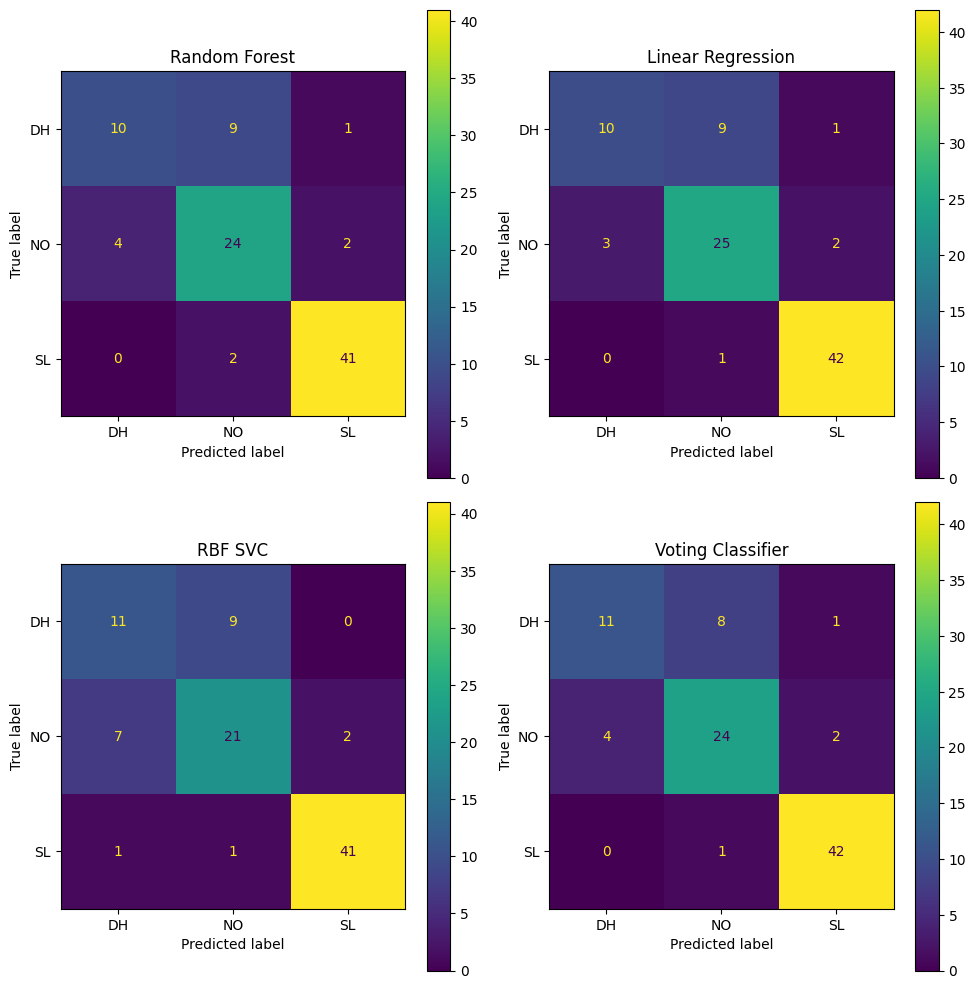

In [184]:
fig, axes = plt.subplots(2,2,figsize=(10,10))
ax = axes.reshape(-1)[0]
ax.title.set_text('Random Forest')
ConfusionMatrixDisplay.from_estimator(rf_bs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[1]
ax.title.set_text('Linear Regression')
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[2]
ax.title.set_text('RBF SVC')
ConfusionMatrixDisplay.from_estimator(rsvc_gs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[3]
ax.title.set_text('Voting Classifier')
ConfusionMatrixDisplay.from_estimator(vs1, X_test_s, y_test, ax=ax)
plt.tight_layout()

In [185]:
results.sort_values(by=['test acc'], ascending=False)

,test acc,precision score (W),recall score (W),f1 score (W)
Logistic Regression,0.827957,0.827382,0.827957,0.819824
Voting Classifier,0.827957,0.823851,0.827957,0.822301
Random Forest,0.806452,0.805649,0.806452,0.800508
RBF SVC,0.784946,0.776566,0.784946,0.779699


Vemos que de los cuatro, el mdejor es el de Regresión logistica, muy empatado con el de votación. 
Esto nos hace suponer, que en el momento de las votaciones, mas o menos todos los modelos estavan de acuerdo con las etiquetas de los ejemplos, es decir, que los 3 modelos confundian los mismos ejemplos.
Esto se puede dever a datos erroneos, outliers o otros factores. No hay que olvidar que el campo de la medicina es un campo muy complejo y que hay diversos factores que pueden influir a las dolencias.